### A Brief History
The field of elliptic&ndash;curve mathematics predates its applications in public&ndash;key cryptography by some 1,800 years. But in 1985, mathematician Neal Koblitz (and, independently, Victor S. Miller) dragged it from the depths of theoretical obscurity into the practical realm.

In a paper titled [*Elliptic Curve Cryptosystems*](https://www.ams.org/journals/mcom/1987-48-177/S0025-5718-1987-0866109-5/S0025-5718-1987-0866109-5.pdf), Koblitz suggested that elliptic curves over finite fields were analogous&mdash;and perhaps even superior&mdash;to existing, practical implementations of public&ndash;key cryptography; in particular, those based on the multiplicative groups conceived by Whitfield Diffie and Martin Hellman in their seminal 1976 paper [*New Directions in Cryptography*](https://ee.stanford.edu/~hellman/publications/24.pdf), and later cleverly adapted to schemes such as public&ndash;key encryption and digital signature by [Taher Elgamal](https://en.wikipedia.org/wiki/Taher_Elgamal).

The efficacy of Diffie&ndash;Hellman style key agreement protocols relied on the difficulty of solving a one&ndash;way function known as the *discrete logarithm problem*, or *DLP*. With the contributions of Koblitz and Miller, elliptic&ndash;curve implementations of the DLP (known as *ECDLP*) have largely overtaken their multiplicative&ndash;group brethren due to their superior performance and security characteristics.

### An Elliptic Curve Over the Real Numbers
They say a picture is worth a thousand words. So it is very helpful to see what at an ellipctic curve actually looks like before discussing its use in cryptography. Using Python, we can plot such a curve over the real numbers.

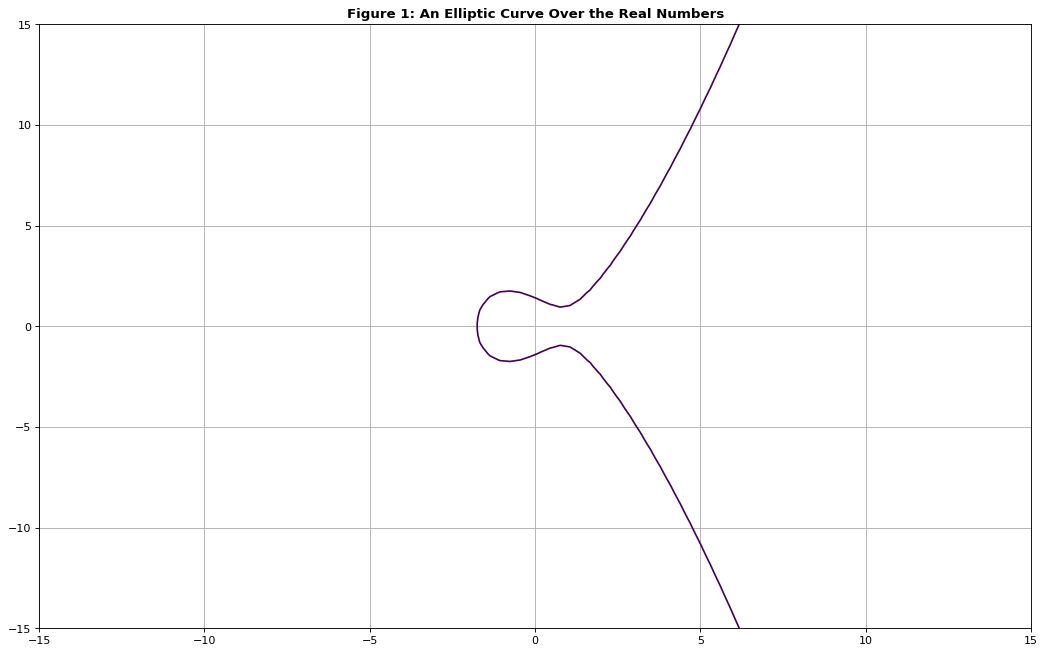

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10), dpi=80)

y, x = np.ogrid[-15:15:100j, -15:15:100j]
a, b = -2, 2
plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.title("Figure 1: An Elliptic Curve Over the Real Numbers", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

The elliptic curves used in public&ndash;key cryptography are over finite fields, which are confined to the integers (i.e., numbers without fractional components). But graphing curves over finite fields is not particularly compelling visually.

However, graphing elliptic curves over the real numbers (i.e., numbers *with* fractional components) gives us an excellent mental model for understanding their use in ellipctic curve cryptography.

Algebraically, the curve in *Figure 1* is defined by the equation *y<sup>2</sup> = x<sup>3</sup> + ax + b*, where *a* and *b* are constant coeffients that determine the shape of the curve (in the curve in *Figure 1*, *a = -2* and *b = 2*), and *x* and *y* are coordinate pairs that define the line of the curve.

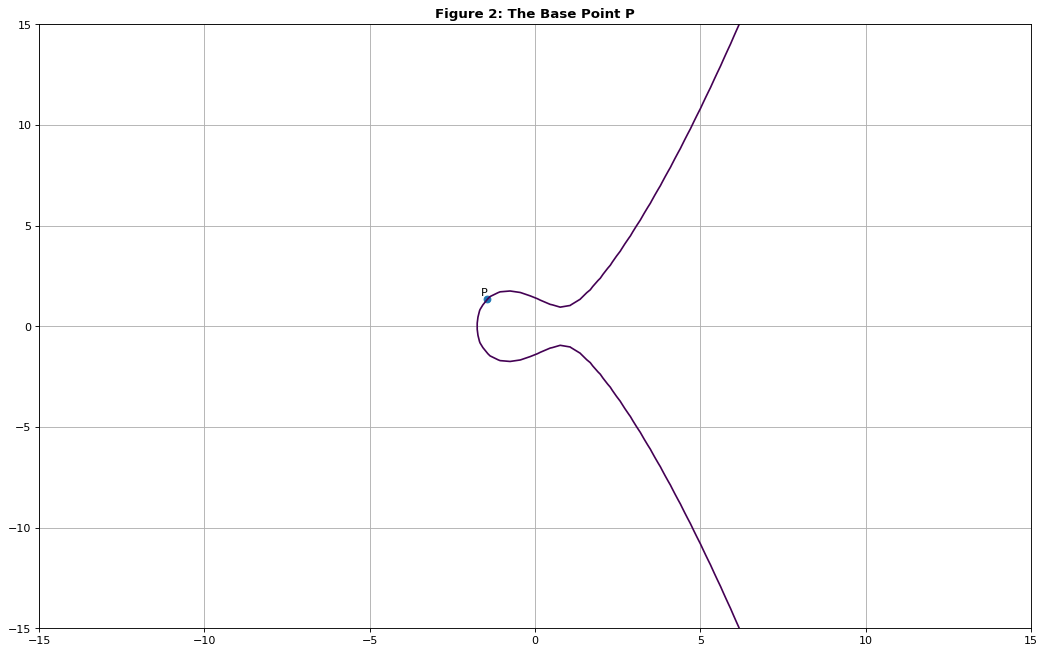

In [2]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

Px, Py = -1.45221053, 1.33333333
plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

plt.title("Figure 2: The Base Point P", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

### The Base Point
In *Figure 2* we plot a single point *P* on the curve at the coordinates *x = -1.45221053* and *y = 1.33333333*. Let's call *P* the *base*, or *generator*, point.

You may recall that multiplicative groups also have generators (also known as a *primitive elements*). These generators are the elements in the group that, when raised to consecutive powers, generate every other element in the group. The base point on an elliptic curve is analagous to the generator in a multiplicative group.

### Point Addition
It is possible to *add* two points on an elliptic curve. The result, or *sum*, of this addition is a third point on the curve.

To add two distinct points *P* and *Q* on a curve, you draw a straight line between them. This line will (almost) always intersect the curve at a third point (the exception is where the *x* coordinates of *P* and *Q* are the same). This 3<sup>rd</sup> point of intersection is called *-R*, which is the *additive inverse* of *P + Q*. To find the sum, you draw a vertical line through *-R*, and the point where this line intersects the curve is called *R*, which gives us *P + Q = R*.

If this seems confusing, it is; but *Figure 3* below should make it more clear.

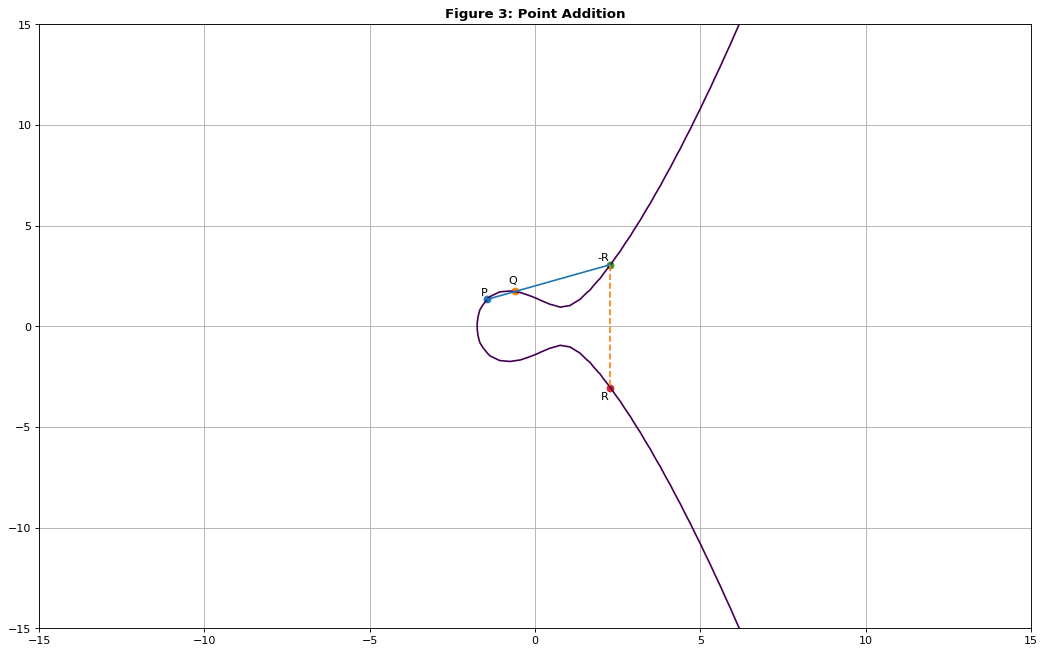

In [3]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

Qx, Qy = -.60606061, 1.72499344

plt.scatter(Qx, Qy)
plt.annotate("Q", [Qx-.2, Qy+.4])

def add(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    x3 = pow(slope, 2) - (x2 + x1)
    y3 = slope * (x2 - x3) - y2
    return x3, y3

Rx, Ry = add(Px, Py, Qx, Qy)

plt.scatter(Rx, -Ry)
plt.annotate("-R", [Rx-.4, -Ry+.2])
plt.plot([Px,Qx,Rx], [Py,Qy,-Ry])

plt.scatter(Rx, Ry)
plt.annotate("R", [Rx-.3, Ry-.6])
plt.plot([Rx, Rx], [-Ry, Ry], linestyle="--")

plt.title("Figure 3: Point Addition", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In *Figure 3*, the point *R* is the sum of the points *P* and *Q* on the elliptic curve (and *-R* is the additive inverse of *R*).

### Point Doubling
So far, we've added two *distinct* points *P* and *Q* to get a third point *R*. But in a cryptographic implementation, we are given just a single starting point; the base point *P*.

To generate a second point (and all subsequent points on the curve) from a single base point, we add the base point to *itself*, as in *P + P*. This is done by drawing a straight line where the base point *P* is *tangent* to the curve, and finding the point of intersection, just like we did when we added *P + Q*.

Another way of saying that we are adding a point to itself is that we are *doubling* a point, as in *P + P = 2P*.

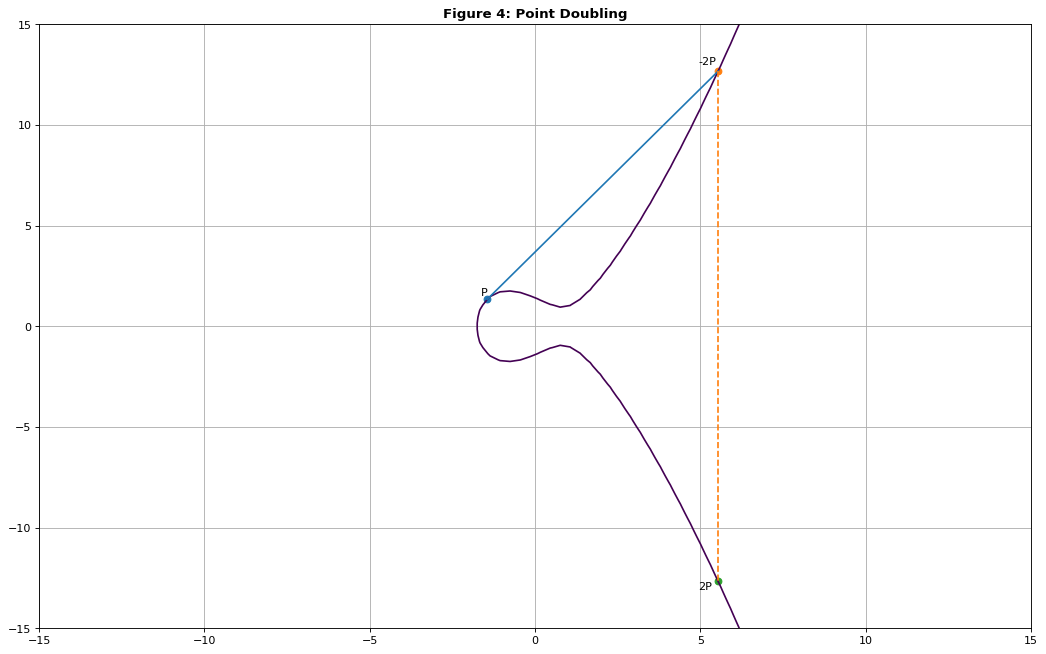

In [4]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

def double(x, y, a):
    slope = ((3 * pow(x, 2)) + a) / (2 * y)
    x1 = pow(slope, 2) - 2 * x
    y1 = slope * (x - x1) - y
    return x1, y1

P2x, P2y = double(Px, Py, a)

plt.scatter(P2x, -P2y)
plt.annotate("-2P", [P2x-.6, -P2y+.3])
plt.plot([Px,P2x], [Py,-P2y])

plt.scatter(P2x, P2y)
plt.annotate("2P", [P2x-.6, P2y-.4])
plt.plot([P2x,P2x], [-P2y,P2y], linestyle="--")

plt.title("Figure 4: Point Doubling", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In *Figure 4*, we've added *P* to itself, or doubled *P*. Again, to double the base point *P* (or any point for that matter), you draw a line tangent to the curve at *P*, find the point of intersection with the curve *-2P*, and take its additive inverse *2P*.

Now that we have *2P*, let's add *P* again to *2P*, which will give us *3P*.

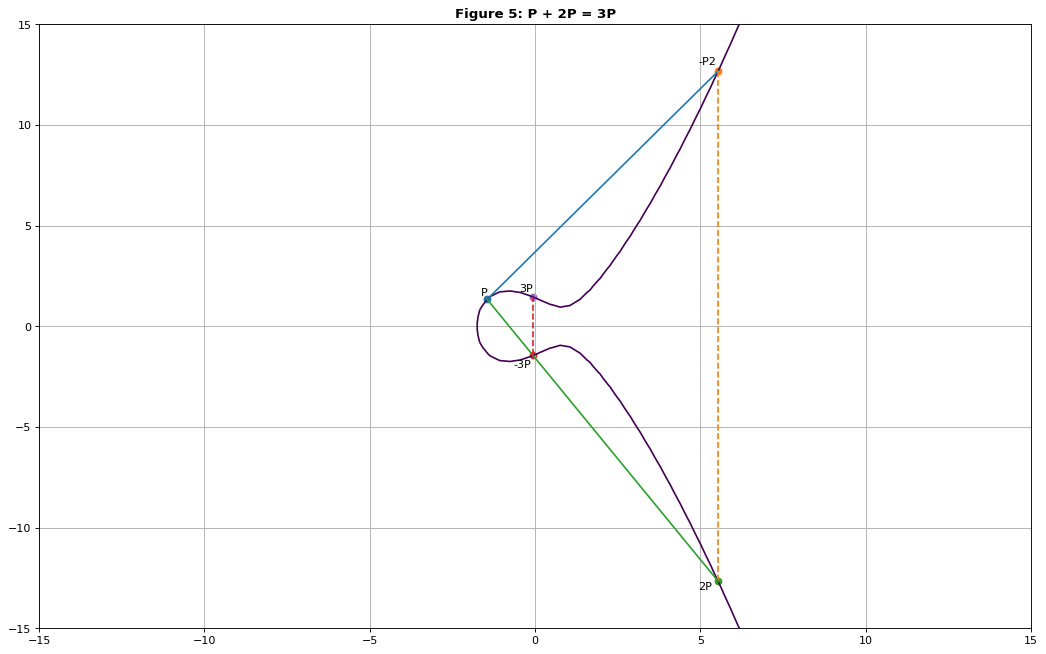

In [5]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

plt.scatter(P2x, -P2y)
plt.annotate("-P2", [P2x-.6, -P2y+.3])
plt.plot([Px,P2x], [Py,-P2y])

plt.scatter(P2x, P2y)
plt.annotate("2P", [P2x-.6, P2y-.4])
plt.plot([P2x,P2x], [-P2y,P2y], linestyle="--")

P3x, P3y = add(Px, Py, P2x, P2y)

plt.scatter(P3x, -P3y)
plt.annotate("-3P", [P3x-.6, -P3y-.6])
plt.plot([P2x,Px], [P2y,Py])

plt.scatter(P3x, P3y)
plt.annotate("3P", [P3x-.4, P3y+.3])
plt.plot([P3x,P3x], [-P3y,P3y], linestyle="--")

plt.title("Figure 5: P + 2P = 3P", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In *Figure 5*, we've used the same technique to add *P* and *2P* that we used to add *P* and *Q* in *Figure 3*; that is, we drew a straight line between *P* and *2P*, found the point of intersection with the curve *-3P*, and took its y&ndash;axis reflection *3P* as the sum of the addition. Algebraically, this translates to *P + 2P = 3P*.

Having established the rules for addition (and doubling) on an elliptic curve, we now have the tools to implement a one-way function that allows us to use the elliptic curve in a cryptographic scheme.

### The Elliptic Curve Discrete Logarithm Problem
The discrete logarithm problem, as conceived by Diffie and Hellman, boils down to the difficulty of determining the value of an exponent given just its base, and the result of the exponent's application to this base. Algebraically, this translates to the question, what is the value of *y* in the equation *x<sup>y</sup> = z*? (Actually, in the realm of multiplicative groups, this should in fact be the congruence relation *x<sup>y</sup> &Congruent; z (mod p)*; but, to keep things simple, we'll just say it's an equation.)

Another way of asking this question is, how many times must *x* be multiplied to itself to produce *z*? It turns out this equation is very easy to compute in the *forward* direction&mdash;that is, given *x* and *y*, it is very easy to determine the value of *z*&mdash;but very hard to compute in the *reverse* direction. This is why the DLP is referred to as a *one-way function*.

With elliptic curves we can pose an analogous question: Given a point *Q*, how many times must you add the base point *P* to itself to reach *Q*? Algebraically, this translates to the question, what is the value of *d* in the equation *d x P = Q*, where *d* is the number of repeated additions of *P*? While it is very easy to compute *Q* given *d* and *P*, it turns out to be very difficult to compute *d* given *Q* and *P*.

In a cryptographic scheme, *d* can be thought of as the private key, and *Q* the public key. And whereas it is very easy for a user (say, Alice) to generate an elliptic&ndash;curve key pair *d* and *Q*, publish *Q* widely, and participate in a secure key exchange with another user (say, Bob), it is very difficult for an eavesdropper (say, Eve) to recover *d* from the public parameters *Q* and *P*.

The discerning reader may now wonder, why is it any more difficult for our adversary, Eve, to compute the private key *d*, given *Q* and *P*, than it is for Alice to compute *Q* given *d* and *P*? After all, Alice must perform *d* additions of *P* to compute *Q*, which is exactly the same number of additions Eve must perform to find *Q* (thereby revealing the value of the private key *d* to Eve).

### Double-and-Add
It turns out we've already seen the answer, and it has to do with point doubling. Because Alice knows the value of *d* in advance, she enjoys a crucial advantage over Eve.

Let's say Alice has selected *d* using a cryptographically secure pseudo-random number generator (CSPRNG); note that *d* is selected from the interval *1 < d < n*, where *n* is the number of points on the curve. If Alice is using a cryptographically secure curve, this means that *d* will be an astronomically large number and, moreover, because it was generated by a CSPRNG, impossible for Eve to guess.

Alice's advantage is that her advance knowledge of *d* allows her to use a shortcut to compute *Q* that Eve cannot use. By scanning the binary representation of *d* (i.e., its bit pattern), Alice simply doubles points (starting with the base point *P*) for every bit she scans, starting with the most significant bit (i.e., from left to right). If she sees a *1* bit, she adds *P* to the running total; and if she sees a *0* bit, she simply doubles the running total and moves on to the next bit.

For example, let's say *d = 26*, the binary representation of which is *11010*. Whereas Eve must perform 26 point additions to find *Q*, Alice must perform only 6. Put another way, Alice can compute *Q* in logarihmic time, whereas Eve must compute *d* in linear time. If *d* is big enough, linear time won't cut it, and Eve won't even bother trying.

Let's put this double-and-add technique to the test in *Figure 6*.

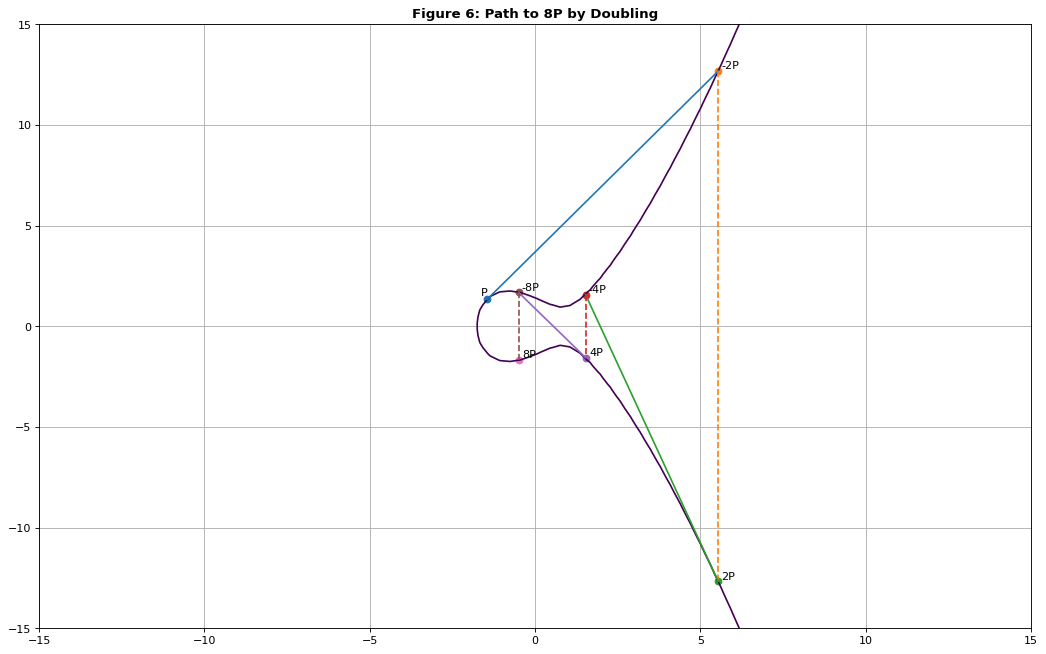

In [6]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

xs, ys = [Px], [Py]
X, Y = Px, Py
for i in range(1,4):
    X, Y = double(X, Y, a)

    plt.scatter(X, -Y)
    plt.annotate(f"{-(1<<i)}P", [X+.1, -Y+.1])
    xs.append(X)
    ys.append(-Y)
    plt.plot(xs, ys)
    xs = xs[1:]
    ys = ys[1:]

    plt.scatter(X, Y)
    plt.annotate(f"{1<<i}P", [X+.1, Y+.1])
    xs.append(X)
    ys.append(Y)
    plt.plot(xs, ys, linestyle="--")
    xs = xs[1:]
    ys = ys[1:]

plt.title("Figure 6: Path to 8P by Doubling", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In *Figure 6*, we've taken *log<sub>2</sub>(8)*, or *3*, steps to find the point at *8P*; specifically, we used 3 doubling operations to arrive at *8P*.

In *Figure 7*, let's compute *8P* using just point addition (note that since we are starting with only a single base point, we must use point doubling on the first iteration of the loop).

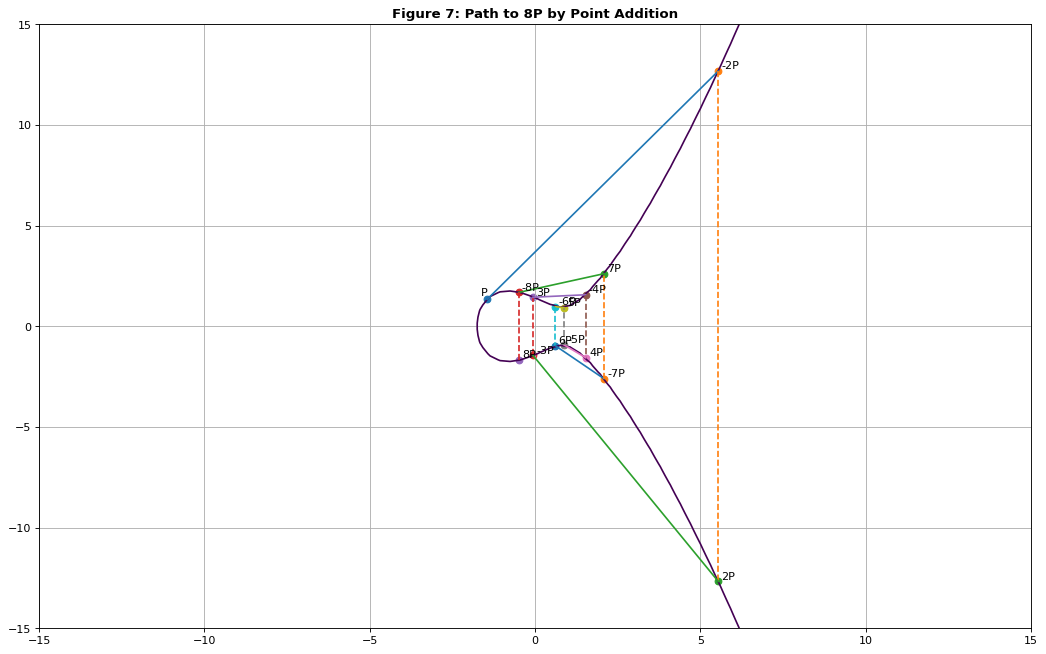

In [7]:
plt.figure(figsize=(16,10), dpi=80)

plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - a*x - b, [0])

plt.scatter(Px, Py)
plt.annotate("P", [Px-.2, Py+.2])

xs, ys = [Px], [Py]
X, Y = Px, Py
for i in range(1,8):
    if i == 1:
        X, Y = double(X, Y, a)
    else:
        X, Y = add(Px, Py, X, Y)

    plt.scatter(X, -Y)
    plt.annotate(f"{-(i+1)}P", [X+.1, -Y+.1])
    xs.append(X)
    ys.append(-Y)
    plt.plot(xs, ys)
    xs = xs[1:]
    ys = ys[1:]

    plt.scatter(X, Y)
    plt.annotate(f"{i+1}P", [X+.1, Y+.1])
    xs.append(X)
    ys.append(Y)
    plt.plot(xs, ys, linestyle="--")
    xs = xs[1:]
    ys = ys[1:]

plt.title("Figure 7: Path to 8P by Point Addition", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

In *Figure 7*, we've arrived at the same point using point addition that we did using point&ndash;doubling in *Figure 6* (*8P*); but using point addition it took us 5 more steps to get there.

Of course, for this trivially small value of *d*, the time savings of 5 steps is negligible. As the size of *d* increases, however, this savings grows exponentially. And, as we now know, in a real&ndash;world implementation *d* will be an unfathomably large number.

### An Elliptic Curve Over a Finite Field
For reasons mentioned at the outset, we have used elliptic curves over the real numbers throughout this demonstration. We also mentioned that the elliptic curves used in cryptography are over finite fields.

To conclude the demonstration, I thought it might be interesting to plot a curve over a finite field, just to see how it looks compared to the curves we've been working with so far.

To do this, I have employed the services of the [ec.py](https://github.com/dchampion/crypto/blob/master/code/src/ec.py) module, which implements some of the elliptic curve primitives we have been discussing here (note that although the code in this module may be of academic interest, it should not be used to secure sensitive data in real applications).

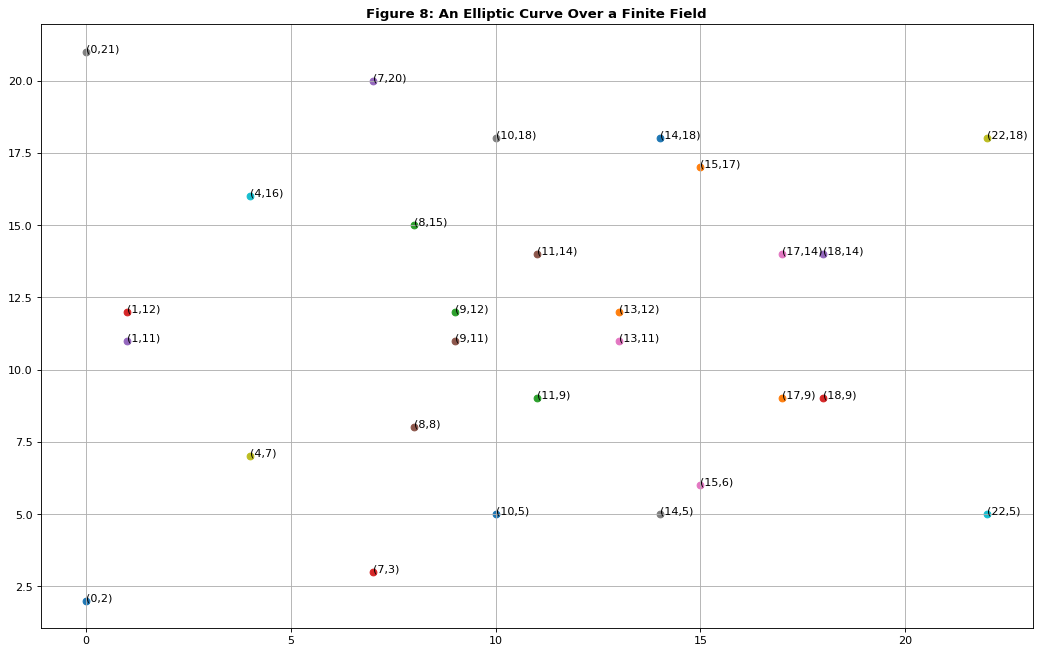

In [8]:
sys.path.append("../code/src")
import ec

plt.figure(figsize=(16,10), dpi=80)

np.ogrid[0:30:100j, 0:30:100j]

ec.new_curve(23,1,4,0,2,29,1,5)

pt = ec._G
plt.scatter(pt[0], pt[1])
plt.annotate(f"({pt[0]},{pt[1]})", [pt[0], pt[1]])

while pt != ec._i:
    pt = ec.add(ec._G, pt)
    plt.scatter(pt[0], pt[1])
    if pt != ec._i:
        plt.annotate(f"({pt[0]},{pt[1]})", [pt[0], pt[1]])

plt.title("Figure 8: An Elliptic Curve Over a Finite Field", fontsize="large", fontweight="bold")
plt.grid()
plt.show()

The most obvious thing to note about *Figure 8* is that there's no *curve* there, at least not in the geometric sense we've seen in previous figures.

Algebraically, however, this is still very much an elliptic curve. Recall that the equation for an elliptic curve over the real numbers is *y<sup>2</sup> = x<sup>3</sup> + ax + b*. But, for an elliptic curve over a finite field, the equation (or *congruence relation*) is *y<sup>2</sup> &Congruent; x<sup>3</sup> + ax + b (mod p)*.

Note that all terms in this relation are taken modulo *p* (which, incidentally, must be a prime number), which confines our curve points to a finite field. In the curve in *Figure 8* that field consists of just 29 points (this number is called *order* of the curve). However, in a cryptographically strong curve, its order would be a very large number; something like 80 decimal digits in length.

Finally, I've annotated each point in the curve with its *xy* coordinates. These too are integers, which themselves are confined to the interval *0 <= x|y < p*, where *p* again is the prime modulus.

Geometrically, elliptic curves over finite fields could not be more different from those over the real numbers. Algebraically, however, they behave almost exacly the same, and therefore provide a novel implementation of the discrete logarithm problem suitable for use in cryptographic schemes.